# Model Creation and FE Simulation

There are several ways to run FEMAG with femagtools: either using an existing FSL script or
 - by using a parametrized stator and magnet model or a user specified FSL fragment
 - by using an existing NC/I7/A7 model file
 
optionally in combination with one of the 7 FE simulation functions: cogg_calc, pm_rel_sim_fast, pm_sym_loss, mult_cal_fast, torq_calc, ld_lq_fast, psd_psq_fast.

In [1]:
import femagtools

Create the FSL command by referencing a model name:

In [2]:
femagtools.create_fsl('PM_270_L8')

['-- created by femagtools 1.4.5dev',
 '',
 '  exit_on_error=false',
 '  exit_on_end=false',
 '  verbosity=1',
 '',
 "model = 'PM_270_L8'",
 'load_model(model)',
 '',
 'm.num_poles = get_dev_data("num_poles")',
 'm.num_pol_pair = m.num_poles/2',
 'm.npols_gen = get_mod_data("num_poles")',
 'm.arm_length = get_dev_data("arm_length")',
 '',
 'global_unit("mm")',
 'cosys("polar")',
 '',
 '',
 'm.hc_min          =        95.000 --   Limit demagnetisa > 0:[%]Hc,<0:[kA/m]   ',
 'm.con_hdcopy      =         0.000 --   Hc-copy:Name:auto:0,intact:1, none:-1   ',
 'm.b_max           =         2.400 --   Max Induction [T] in colorgradation     ',
 'm.b_min           =         0.000 --   Move inside: 0 , Move outside: > 0      ',
 'm.calc_fe_loss    =         1.000 --   Calc. FE-Loss:0:no, 1:yes, 2:m-output   ',
 'm.eval_force      =         0.000 --   Eval. force density > 0, no <= 0        ',
 'm.allow_draw      =         1.000 --   Draw Graphics :> 0: yes, 0:  no         ',
 'm.fline_dens      

This produces a list of FSL commands which can be written to a file:

In [3]:
with open('femag.fsl', 'w') as f:
    f.write('\n'.join(femagtools.create_fsl('PM_270_L8')))

Note: The explicit creation of an FSL file is often not necessary. 

The FSL commands to build a FEMAG model can be generated from parameterized stator and magnet models. This is done by setting up a dict variable that contains a general set of parameters together with the stator, magnet and winding dicts:

In [4]:
machine = {
    "name": "PM 270 L8",
    "desc": "PM Motor 270mm 8 poles VMAGN",
    "poles": 8,
    "outer_diam": 0.26924,
    "bore_diam": 0.16192,
    "inner_diam": 0.11064,
    "airgap": 0.00075,
    "lfe": 0.08356,
    "stator": {
        "num_slots": 48,
        "mcvkey_yoke": 'M270-35A',
        "statorRotor3": {
            "slot_height": 0.0335,
            "slot_h1": 0.001,
            "slot_h2": 0.0,
            "slot_width": 0.00193,
            "slot_r1": 0.0001,
            "slot_r2": 0.00282,
            "wedge_width1": 0.00295,
            "wedge_width2": 0.0,
            "middle_line": 0.0,
            "tooth_width": 0.0,
            "slot_top_sh": 0.0}
    },
    "magnet": {
        "mcvkey_yoke": 'M270-35A',
        "nodedist": 4,
        "magnetIronV": {
            "magn_angle": 145.0,
            "magn_height": 0.00648,
            "magn_width": 0.018,
            "condshaft_r": 0.05532,
            "magn_num": 1.0,
            "air_triangle": 1,
            "iron_hs": 0.0,
            "gap_ma_iron": 0.0002,
            "iron_height": 0.00261,
            "magn_rem": 1.2,
            "iron_shape": 0.0802
        }
    },
    "windings": {
        "num_phases": 3,
        "num_layers": 1,
        "num_wires": 9,
        "coil_span": 6.0,
        "cufilfact": 0.4,
        "culength": 1.4,
        "slot_indul": 0.5e-3
    }
}

With this model description it is possible to create the FSL file using the built-in templates "statorRotor3" and "magnetIronV". To do so we create a working directory and write the FSL file in this directory. But let's first configure a logger to get some useful runtime information:

In [5]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')

Now the FSL file is created:

In [6]:
import pathlib
workdir = pathlib.Path.home() / 'femag'
workdir.mkdir(parents=True, exist_ok=True)
fslfile = workdir / 'femag.fsl'
fslfile.write_text('\n'.join(femagtools.create_fsl(machine)))

2023-10-20 16:43:35,175 [24, 48]
2023-10-20 16:43:35,176 create new model 'PM270L8'


4735

This machine model uses the lamination material "M270-35A" which must be defined. In our case a corresponding MC/MCV file exists in the current directory. We can copy it into the working directory:

In [7]:
import femagtools.mcv
magnetizingCurves = femagtools.mcv.MagnetizingCurve('.')
magnetizingCurves.writefile('M270-35A', workdir)

2023-10-20 16:43:35,198 MC Dir /home/tar/projects/femagtools/notebooks
2023-10-20 16:43:35,199 Copy file M270-35A.MCV


'M270-35A.MCV'

After these steps FEMAG can execute the created FSL file:

In [8]:
femag = femagtools.femag.Femag(workdir, magnetizingCurves=magnetizingCurves)
femag.run(fslfile, options=['-g'])

2023-10-20 16:43:35,206 invoking /home/tar/bin/xfemag64 -g /home/tar/femag/femag.fsl
2023-10-20 16:43:35,227  > FSL...exe "/home/tar/femag/femag.fsl"
2023-10-20 16:43:35,228  > New model "PM270L8", ""
2023-10-20 16:43:36,974  > Save model and continue
2023-10-20 16:43:36,995  > FSL...halt
2023-10-20 16:43:37,003 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)


But there is a simpler approach without file handling. Our femag object can do the necessary steps based on the machine model:

In [9]:
femag(machine)

2023-10-20 16:43:37,007 search file M270-35A.MCV in /home/tar/projects/femagtools/notebooks
2023-10-20 16:43:37,007 search file M270-35A.MCV in /home/tar/projects/femagtools/notebooks
2023-10-20 16:43:37,007 Copy file M270-35A.MCV
2023-10-20 16:43:37,008 create new model 'PM270L8'
2023-10-20 16:43:37,032 invoking /home/tar/bin/xfemag64 -b femag.fsl
2023-10-20 16:43:37,046  > FSL...exe "femag.fsl"
2023-10-20 16:43:37,047  > New model "PM270L8", ""
2023-10-20 16:43:38,705  > Save model and continue
2023-10-20 16:43:38,726  > FSL...halt
2023-10-20 16:43:38,734 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)


{'status': 'ok', 'message': 'PM270L8'}

Now lets check if the mesh complies to our requirements. For this the created NC file can be used:

In [10]:
nc = femag.read_nc()

2023-10-20 16:43:39,296 Total nodes 5544 elements 7761 superelements 101 subregions 12


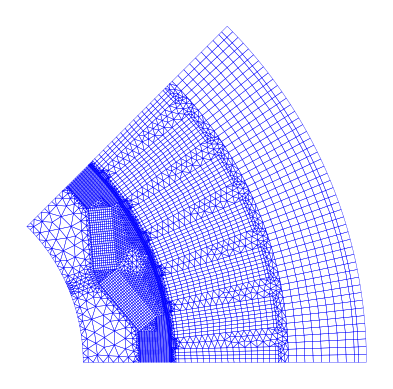

In [11]:
import femagtools.plot.nc
femagtools.plot.nc.mesh(nc)

For the FE simulation an additional dict must be setup:

In [12]:
simulation = {
    "angl_i_up": -30.0,
    "calculationMode": "pm_sym_fast",
    "num_move_steps": 31,
    "wind_temp": 60.0,
    "magn_temp": 60.0,
    "current": 150.0,
    "speed": 50.0,
    "period_frac": 6,
    "airgap_induc": True
}

Now we can invoke FEMAG without creating an FSL file. The Femag object knows how to handle this:

In [13]:
r = femag(machine, simulation, options=['-g'])

2023-10-20 16:43:42,011 Copy file M270-35A.MCV
2023-10-20 16:43:42,011 create new model 'PM270L8'
2023-10-20 16:43:42,032 create simulation 'pm_sym_fast'
2023-10-20 16:43:42,039 invoking /home/tar/bin/xfemag64 -g femag.fsl
2023-10-20 16:43:42,060  > FSL...exe "femag.fsl"
2023-10-20 16:43:42,061  > New model "PM270L8", ""
2023-10-20 16:43:46,317  > 1   5.27713237E-05
2023-10-20 16:43:51,359  > 1   6.99858298E-04
2023-10-20 16:43:51,850  > 1   6.50105008E-04
2023-10-20 16:43:58,196  > Save model and close files
2023-10-20 16:43:58,225  > FSL...halt
2023-10-20 16:43:58,250 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)
2023-10-20 16:43:58,253 Read BCH /home/tar/femag/PM270L8_069.BATCH
2023-10-20 16:43:58,257 flux density: 8 poles B amp 1.543886 


In [14]:
r.machine['p']

4

After a calculation has finished the BCH values are included in the returned object 'r'. For example the torque:

In [15]:
r.machine['torque']

298.2299

If we had set the parameter 'airgap_induc' to True we can access the produced airgap values and create a nice plot including the base harmonic:

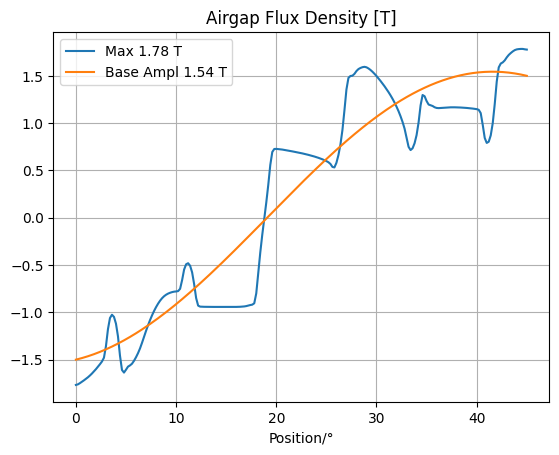

In [16]:
import matplotlib.pylab as plt
import femagtools.plot
femagtools.plot.airgap(r.airgap)
plt.show()

We can even create a graphical report of the results:

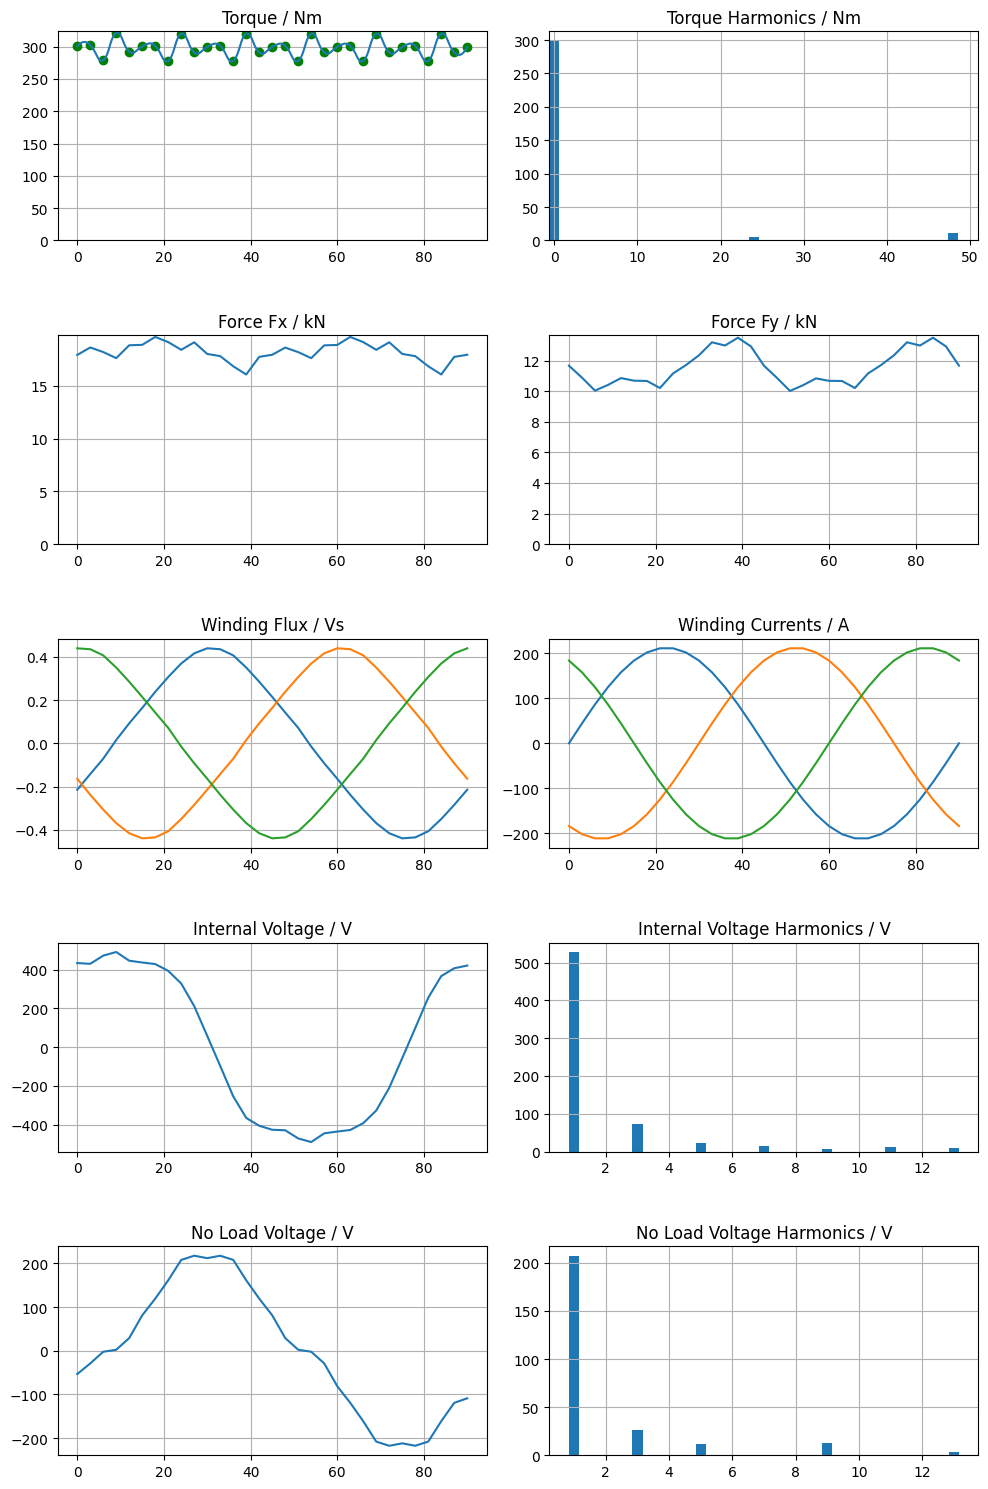

In [17]:
import femagtools.plot.bch
femagtools.plot.bch.pmrelsim(r)

## Model creation with user specific model

A user specific model is based on a FSL file that includes the necessary nodechain and material definitions. This script can then be included in the magnet dict of the machine. In the following example the file is named 'spokefml.fsl':

In [18]:
machine['magnet'] = dict(
        mcvkey_yoke='M270-35A',
        spokefml=dict(
            magn_height=0.008,
            shaft_diam=0.01,
            slot_width=0.004,
            magn_width=0.022
        )
)

The FSL fragment should make use of the globally defined variables as described in the femagtools documentation.

In [19]:
fslfile = workdir / 'femag.fsl'
fslfile.write_text('\n'.join(femagtools.create_fsl(machine)))
femag.run(str(fslfile), options=['-g'])

2023-10-20 16:43:59,323 create new model 'PM270L8'
2023-10-20 16:43:59,344 invoking /home/tar/bin/xfemag64 -g /home/tar/femag/femag.fsl
2023-10-20 16:43:59,367  > FSL...exe "/home/tar/femag/femag.fsl"
2023-10-20 16:43:59,369  > New model "PM270L8", ""
2023-10-20 16:43:59,866  > fml 0.33 (c) 2012-2017 Siemens AG
2023-10-20 16:44:02,972  > Save model and continue
2023-10-20 16:44:03,001  > FSL...halt
2023-10-20 16:44:03,010 /home/tar/bin/xfemag64 exited with returncode 0 (num errs=0)


The resulting geometry can be plotted:

2023-10-20 16:44:04,179 Total nodes 8153 elements 14365 superelements 89 subregions 12


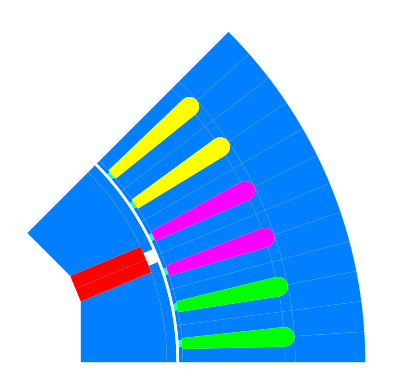

In [20]:
nc = femag.read_nc()
femagtools.plot.spel(nc)